<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/new-dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:

# !pip install torch torchvision torchaudio scikit-learn matplotlib pillow
import os, math, random, copy, numpy as np
from pathlib import Path
from PIL import Image
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision import transforms, models, datasets
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

In [226]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print("Device:", device)
SEED=42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False

Device: cuda


In [227]:

# Prefilled with your uploaded CSVs and label_map in /mnt/data
TRAIN_CSV = "/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv"
VAL_CSV   = "/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv"
TEST_CSV  = "/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv"
LABEL_MAP = "/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json"
IMAGES_ROOT = "/content/ann-visual-emotion/data/raw/EmoSet"

MODEL   = "resnet18"      # or "simple_cnn"
EPOCHS  = 30
BATCH   = 128
LR      = 3e-4
IMG_SZ  = 224 if MODEL=="resnet18" else 96
SAVE_DIR= "./checkpoints_csv_prefilled"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)


In [228]:

def read_label_map(p):
    with open(p,"r") as f: lm = json.load(f)
    str2idx = dict(lm); idx2str = {v:k for k,v in str2idx.items()}
    return str2idx, idx2str

def find_col(cols, cands):
    cols_lower=[c.lower() for c in cols]
    for cand in cands:
        if cand in cols_lower: return cols[cols_lower.index(cand)]
    raise ValueError(f"Need one of {cands}, have {cols}")

class CSVDataset(Dataset):
    def __init__(self, csv_path, label_map, images_root="", transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform=transform; self.images_root=images_root; self.label_map=label_map
        self.path_col  = find_col(self.df.columns, ["path","filepath","image","img","file"])
        self.label_col = find_col(self.df.columns, ["label","emotion","class"])
        self.df[self.label_col]=self.df[self.label_col].astype(str)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel = str(row[self.path_col]); path = rel if os.path.isabs(rel) else os.path.join(self.images_root, rel)
        x = Image.open(path).convert("L")
        y = self.label_map[str(row[self.label_col])]
        if self.transform: x = self.transform(x)
        return x, y


In [229]:
def build_transforms(img_size=224, model="resnet18", img_mode="L"):
    # Ensure the output is 1 channel if img_mode is "L"
    if img_mode == "L":
        train_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=1), # Ensure 1 output channel
            transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            # ColorJitter is typically for RGB, consider removing or adjusting for grayscale
            # transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.ToTensor(),
            # Normalize for 1 channel
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        eval_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=1), # Ensure 1 output channel
            transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            # Normalize for 1 channel
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    else: # Assuming RGB
        train_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Keep 3 channels for RGB if needed
            transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        eval_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Keep 3 channels for RGB if needed
            transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])

    return train_tf, eval_tf

# Assuming LABEL_MAP, IMG_SZ, MODEL, IMAGES_ROOT, TRAIN_CSV, VAL_CSV, TEST_CSV, BATCH are defined in previous cells
str2idx, idx2str = read_label_map(LABEL_MAP)
classes = [k for k,_ in sorted(str2idx.items(), key=lambda kv: kv[1])]

# Pass IMG_MODE to build_transforms
train_tf, eval_tf = build_transforms(IMG_SZ, MODEL, IMG_MODE)

ds_tr = CSVDataset(TRAIN_CSV, str2idx, IMAGES_ROOT, transform=train_tf)
ds_va = CSVDataset(VAL_CSV,   str2idx, IMAGES_ROOT, transform=eval_tf)
ds_te = CSVDataset(TEST_CSV,  str2idx, IMAGES_ROOT, transform=eval_tf)

import torch
counts = torch.zeros(len(classes))
for y in ds_tr.df[ds_tr.label_col].astype(str):
    counts[str2idx[y]] += 1
wpc = 1.0/torch.clamp(counts, min=1.0)
sample_weights = [wpc[str2idx[y]].item() for y in ds_tr.df[ds_tr.label_col].astype(str)]
from torch.utils.data import WeightedRandomSampler, DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

tr_loader = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, num_workers=4, pin_memory=True)
va_loader = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
te_loader = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

In [230]:

class SimpleCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=7, dropout=0.3):
        super().__init__()
        c=32
        self.features = nn.Sequential(
            nn.Conv2d(in_ch,c,3,1,1), nn.BatchNorm2d(c), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(c,c*2,3,1,1),   nn.BatchNorm2d(c*2), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(c*2,c*4,3,1,1), nn.BatchNorm2d(c*4), nn.ReLU(), nn.MaxPool2d(2),
        )
        h=IMG_SZ//8
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(c*4*h*h,256), nn.ReLU(),
            nn.Dropout(0.3), nn.Linear(256,len(classes))
        )
    def forward(self,x):
        x=self.features(x); x=torch.flatten(x,1); return self.head(x)

def build_resnet18(num_classes, in_ch=1, pretrained=True, dropout=0.2):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    if in_ch==1:
        w=m.conv1.weight; m.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
        if pretrained:
            with torch.no_grad(): m.conv1.weight[:] = w.mean(dim=1, keepdim=True)
    m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(m.fc.in_features, num_classes))
    return m

net = build_resnet18(len(classes), in_ch=1, pretrained=True, dropout=0.2) if MODEL=="resnet18" else SimpleCNN(in_ch=1, num_classes=len(classes))
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [231]:

from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=1e-4)
steps_per_epoch = max(1, int(len(tr_loader.dataset)/BATCH))
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch) if MODEL=="resnet18" else CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def train_one_epoch(model, loader):
    model.train(); total_loss=total_correct=total=0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            out=model(imgs); loss=criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item()*labels.size(0)
        total_correct += (out.argmax(1)==labels).sum().item()
        total += labels.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); total_loss=total_correct=total=0; all_p, all_y=[], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out=model(imgs); loss=criterion(out, labels)
        total_loss += loss.item()*labels.size(0)
        total_correct += (out.argmax(1)==labels).sum().item()
        total += labels.size(0)
        all_p.append(out.argmax(1).cpu()); all_y.append(labels.cpu())
    all_p=torch.cat(all_p).numpy(); all_y=torch.cat(all_y).numpy()
    f1 = __import__('sklearn.metrics').metrics.f1_score(all_y, all_p, average='macro')
    return total_loss/total, total_correct/total, f1, all_y, all_p

In [235]:
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

Epoch 01 | tr_loss 0.7037 acc 0.820 | val_loss 1.0589 acc 0.673 f1 0.661
Epoch 02 | tr_loss 0.6958 acc 0.825 | val_loss 1.0557 acc 0.674 f1 0.661
Epoch 03 | tr_loss 0.6850 acc 0.831 | val_loss 1.0591 acc 0.671 f1 0.660
Epoch 04 | tr_loss 0.6657 acc 0.841 | val_loss 1.0696 acc 0.671 f1 0.661
Epoch 05 | tr_loss 0.6593 acc 0.842 | val_loss 1.0730 acc 0.675 f1 0.664
Epoch 06 | tr_loss 0.6485 acc 0.850 | val_loss 1.0760 acc 0.675 f1 0.666
Epoch 07 | tr_loss 0.6390 acc 0.852 | val_loss 1.0743 acc 0.674 f1 0.661
Epoch 08 | tr_loss 0.6302 acc 0.857 | val_loss 1.0852 acc 0.672 f1 0.659


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb9e6576980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

KeyboardInterrupt: 

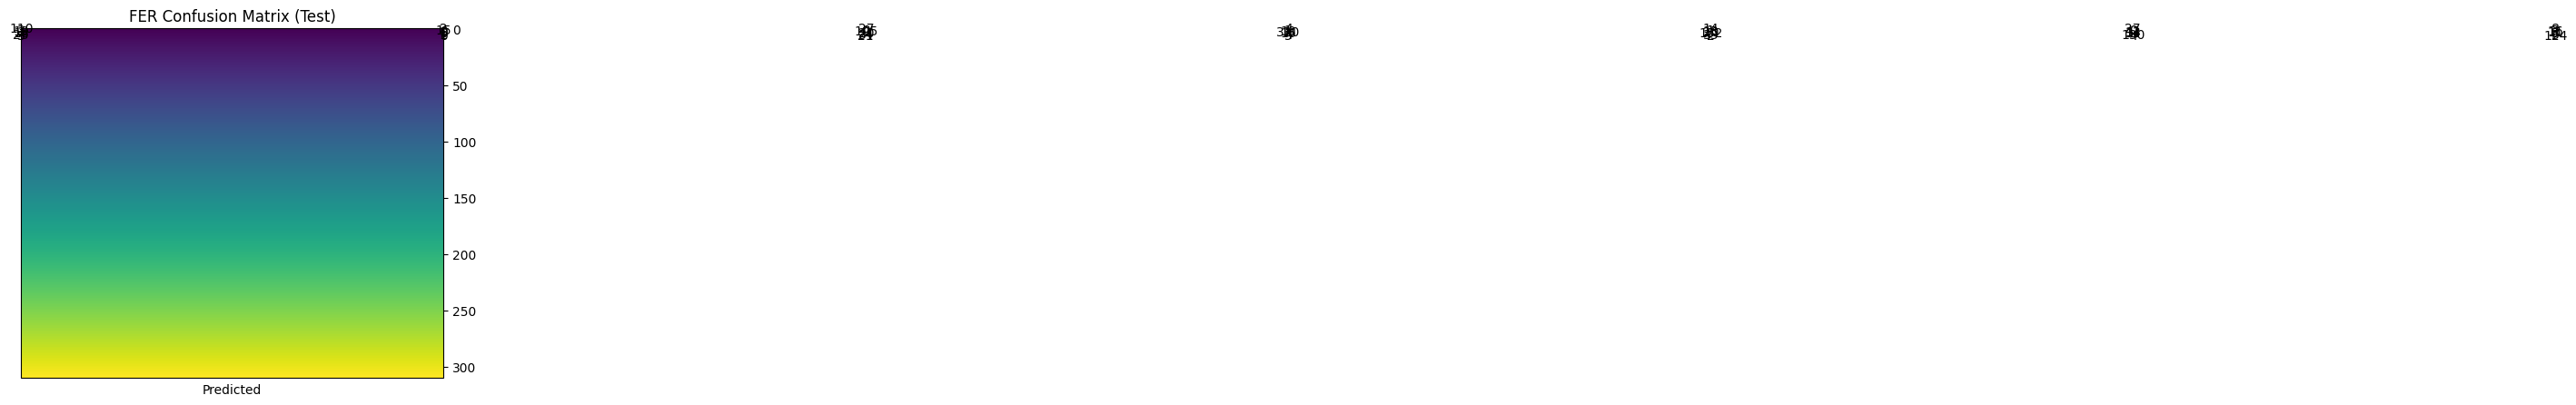

In [234]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, aspect='auto')
ax.set_title("FER Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right'); ax.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.colorbar(im, ax); fig.tight_layout()
fig.savefig(f"{SAVE_DIR}/confusion_matrix.png", dpi=160)

# Task
Improve the accuracy of the image classification model by exploring different hyperparameter settings, data augmentation techniques, model architectures, training schedules, regularization methods, and loss functions.

## Hyperparameter tuning

### Subtask:
Experiment with different learning rates, batch sizes, optimizers, and weight decay values.


**Reasoning**:
I will modify the hyperparameters (LR, BATCH, WEIGHT_DECAY) and the optimizer, then run the training loop to observe the impact on performance.



In [236]:
# Experiment with different hyperparameters
LR = 1e-4  # Reduced learning rate
BATCH = 64 # Reduced batch size
WEIGHT_DECAY = 5e-4 # Increased weight decay

# Try a different optimizer
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Rebuild the dataloaders with the new batch size
tr_loader = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, num_workers=4, pin_memory=True)
va_loader = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
te_loader = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

# Re-define the scheduler with the potentially new steps_per_epoch
steps_per_epoch = max(1, int(len(tr_loader.dataset)/BATCH))
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch) if MODEL=="resnet18" else CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Rerun the training loop
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

Epoch 01 | tr_loss 0.6291 acc 0.858 | val_loss 1.0917 acc 0.675 f1 0.665
Epoch 02 | tr_loss 0.6233 acc 0.860 | val_loss 1.0909 acc 0.680 f1 0.666
Epoch 03 | tr_loss 0.6310 acc 0.857 | val_loss 1.0886 acc 0.677 f1 0.666
Epoch 04 | tr_loss 0.6233 acc 0.861 | val_loss 1.0885 acc 0.677 f1 0.662
Epoch 05 | tr_loss 0.6218 acc 0.862 | val_loss 1.0832 acc 0.679 f1 0.666
Epoch 06 | tr_loss 0.6194 acc 0.863 | val_loss 1.0889 acc 0.676 f1 0.665
Epoch 07 | tr_loss 0.6189 acc 0.862 | val_loss 1.0943 acc 0.677 f1 0.658
Epoch 08 | tr_loss 0.6194 acc 0.861 | val_loss 1.0843 acc 0.681 f1 0.671
Epoch 09 | tr_loss 0.6187 acc 0.862 | val_loss 1.0879 acc 0.680 f1 0.670
Epoch 10 | tr_loss 0.6171 acc 0.864 | val_loss 1.0881 acc 0.678 f1 0.668
Epoch 11 | tr_loss 0.6212 acc 0.860 | val_loss 1.0952 acc 0.675 f1 0.663
Epoch 12 | tr_loss 0.6171 acc 0.862 | val_loss 1.0847 acc 0.681 f1 0.670
Epoch 13 | tr_loss 0.6162 acc 0.863 | val_loss 1.0822 acc 0.682 f1 0.669
Epoch 14 | tr_loss 0.6185 acc 0.862 | val_loss 1.08

## Data augmentation

### Subtask:
Implement more advanced data augmentation techniques beyond the current random horizontal flip and rotation to make the model more robust.


**Reasoning**:
Modify the `build_transforms` function to include more advanced data augmentation techniques suitable for grayscale images if IMG_MODE is "L", otherwise for RGB images.



In [237]:
def build_transforms(img_size=224, model="resnet18", img_mode="L"):
    # Ensure the output is 1 channel if img_mode is "L"
    if img_mode == "L":
        train_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=1), # Ensure 1 output channel
            transforms.RandomResizedCrop(img_size, scale=(0.7,1.0), ratio=(0.75, 1.333333)), # More aggressive cropping
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20), # Increased rotation range
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Add affine transformations
            transforms.ColorJitter(brightness=0.2, contrast=0.2), # Add color jitter for grayscale
            transforms.ToTensor(),
            # Normalize for 1 channel
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        eval_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=1), # Ensure 1 output channel
            transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            # Normalize for 1 channel
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    else: # Assuming RGB
        train_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Keep 3 channels for RGB if needed
            transforms.RandomResizedCrop(img_size, scale=(0.7,1.0), ratio=(0.75, 1.333333)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
        eval_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Keep 3 channels for RGB if needed
            transforms.Resize(int(img_size*1.15)), transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])

    return train_tf, eval_tf

# Re-instantiate datasets and dataloaders with the updated transforms
# Assuming LABEL_MAP, IMG_SZ, MODEL, IMAGES_ROOT, TRAIN_CSV, VAL_CSV, TEST_CSV, BATCH are defined in previous cells
str2idx, idx2str = read_label_map(LABEL_MAP)
classes = [k for k,_ in sorted(str2idx.items(), key=lambda kv: kv[1])]

# Pass IMG_MODE to build_transforms, assuming IMG_MODE is defined
# Define IMG_MODE if it's not defined in previous cells
try: IMG_MODE
except NameError: IMG_MODE = "L" # Default to grayscale if not defined

train_tf, eval_tf = build_transforms(IMG_SZ, MODEL, IMG_MODE)

ds_tr = CSVDataset(TRAIN_CSV, str2idx, IMAGES_ROOT, transform=train_tf)
ds_va = CSVDataset(VAL_CSV,   str2idx, IMAGES_ROOT, transform=eval_tf)
ds_te = CSVDataset(TEST_CSV,  str2idx, IMAGES_ROOT, transform=eval_tf)

# Rebuild sampler for the training dataset
counts = torch.zeros(len(classes))
for y in ds_tr.df[ds_tr.label_col].astype(str):
    counts[str2idx[y]] += 1
wpc = 1.0/torch.clamp(counts, min=1.0)
sample_weights = [wpc[str2idx[y]].item() for y in ds_tr.df[ds_tr.label_col].astype(str)]
from torch.utils.data import WeightedRandomSampler, DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Rebuild dataloaders
tr_loader = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, num_workers=4, pin_memory=True)
va_loader = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
te_loader = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

# Rerun the training loop
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

Epoch 01 | tr_loss 0.8909 acc 0.738 | val_loss 1.1005 acc 0.665 f1 0.646
Epoch 02 | tr_loss 0.8708 acc 0.745 | val_loss 1.1095 acc 0.663 f1 0.637
Epoch 03 | tr_loss 0.8776 acc 0.742 | val_loss 1.1069 acc 0.663 f1 0.639
Epoch 04 | tr_loss 0.8693 acc 0.742 | val_loss 1.0896 acc 0.671 f1 0.649
Epoch 05 | tr_loss 0.8552 acc 0.750 | val_loss 1.0991 acc 0.668 f1 0.644
Epoch 06 | tr_loss 0.8518 acc 0.755 | val_loss 1.0927 acc 0.669 f1 0.651
Epoch 07 | tr_loss 0.8616 acc 0.753 | val_loss 1.0889 acc 0.672 f1 0.651
Epoch 08 | tr_loss 0.8611 acc 0.748 | val_loss 1.0875 acc 0.674 f1 0.652
Epoch 09 | tr_loss 0.8535 acc 0.750 | val_loss 1.0895 acc 0.674 f1 0.652
Epoch 10 | tr_loss 0.8437 acc 0.757 | val_loss 1.0856 acc 0.673 f1 0.657
Epoch 11 | tr_loss 0.8482 acc 0.753 | val_loss 1.0912 acc 0.673 f1 0.650
Epoch 12 | tr_loss 0.8475 acc 0.755 | val_loss 1.0891 acc 0.672 f1 0.650
Epoch 13 | tr_loss 0.8445 acc 0.759 | val_loss 1.0936 acc 0.672 f1 0.648
Epoch 14 | tr_loss 0.8438 acc 0.755 | val_loss 1.08

## Model architecture

### Subtask:
Explore different model architectures or variations of the current ResNet-18 model, potentially using pre-trained weights differently or trying a larger model.


**Reasoning**:
I will modify the `build_resnet18` function to allow building ResNet34 and ResNet50 models, adapt the input layer for grayscale images, and then instantiate a ResNet34 model and rerun the training loop to evaluate its performance.



In [238]:
def build_resnet(model_name, num_classes, in_ch=1, pretrained=True, dropout=0.2):
    if model_name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    elif model_name == "resnet34":
        m = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
    elif model_name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    else:
        raise ValueError(f"Model {model_name} not supported")

    if in_ch == 1:
        w = m.conv1.weight
        m.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        if pretrained:
            with torch.no_grad():
                m.conv1.weight[:] = w.mean(dim=1, keepdim=True)

    m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(m.fc.in_features, num_classes))
    return m

# Use ResNet34
MODEL_ARCH = "resnet34" # Changed from MODEL
net = build_resnet(MODEL_ARCH, len(classes), in_ch=1, pretrained=True, dropout=0.2)
net.to(device)

# Re-define optimizer and scheduler for the new model parameters
optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=1e-4) # Using AdamW again with potentially updated LR
steps_per_epoch = max(1, int(len(tr_loader.dataset)/BATCH))
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch) if MODEL_ARCH.startswith("resnet") else CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Rerun the training loop
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 132MB/s]


Epoch 01 | tr_loss 1.8898 acc 0.247 | val_loss 1.6902 acc 0.380 f1 0.324
Epoch 02 | tr_loss 1.6404 acc 0.389 | val_loss 1.4969 acc 0.472 f1 0.399
Epoch 03 | tr_loss 1.5046 acc 0.452 | val_loss 1.4156 acc 0.498 f1 0.437
Epoch 04 | tr_loss 1.4268 acc 0.486 | val_loss 1.3233 acc 0.540 f1 0.477
Epoch 05 | tr_loss 1.3482 acc 0.523 | val_loss 1.2711 acc 0.561 f1 0.506
Epoch 06 | tr_loss 1.2937 acc 0.548 | val_loss 1.2453 acc 0.574 f1 0.522
Epoch 07 | tr_loss 1.2519 acc 0.569 | val_loss 1.2164 acc 0.582 f1 0.528
Epoch 08 | tr_loss 1.2106 acc 0.584 | val_loss 1.1715 acc 0.601 f1 0.553
Epoch 09 | tr_loss 1.1833 acc 0.599 | val_loss 1.1383 acc 0.622 f1 0.579
Epoch 10 | tr_loss 1.1532 acc 0.612 | val_loss 1.1266 acc 0.627 f1 0.585
Epoch 11 | tr_loss 1.1242 acc 0.625 | val_loss 1.1263 acc 0.630 f1 0.585
Epoch 12 | tr_loss 1.1033 acc 0.635 | val_loss 1.1084 acc 0.634 f1 0.599
Epoch 13 | tr_loss 1.0784 acc 0.644 | val_loss 1.0978 acc 0.642 f1 0.604
Epoch 14 | tr_loss 1.0709 acc 0.649 | val_loss 1.08

## Training schedule

### Subtask:
Adjust the learning rate scheduler or train for more epochs if the model is still improving.


**Reasoning**:
Modify the training loop to train for a higher number of epochs by changing the EPOCHS variable and rerun the training.



In [239]:
# Increase the number of training epochs
EPOCHS = 50

# Re-define the scheduler with the potentially new steps_per_epoch and epochs
steps_per_epoch = max(1, int(len(tr_loader.dataset)/BATCH))
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch) if MODEL_ARCH.startswith("resnet") else CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Rerun the training loop
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

Epoch 01 | tr_loss 0.8820 acc 0.734 | val_loss 1.0161 acc 0.683 f1 0.667
Epoch 02 | tr_loss 0.8804 acc 0.735 | val_loss 1.0139 acc 0.683 f1 0.664
Epoch 03 | tr_loss 0.8613 acc 0.744 | val_loss 1.0138 acc 0.685 f1 0.666
Epoch 04 | tr_loss 0.8545 acc 0.749 | val_loss 1.0178 acc 0.682 f1 0.661
Epoch 05 | tr_loss 0.8524 acc 0.747 | val_loss 1.0213 acc 0.680 f1 0.663
Epoch 06 | tr_loss 0.8453 acc 0.750 | val_loss 1.0166 acc 0.684 f1 0.668
Epoch 07 | tr_loss 0.8332 acc 0.758 | val_loss 1.0124 acc 0.690 f1 0.674
Epoch 08 | tr_loss 0.8332 acc 0.755 | val_loss 1.0174 acc 0.687 f1 0.672
Epoch 09 | tr_loss 0.8218 acc 0.762 | val_loss 1.0184 acc 0.688 f1 0.672
Epoch 10 | tr_loss 0.8132 acc 0.766 | val_loss 1.0147 acc 0.691 f1 0.673
Epoch 11 | tr_loss 0.8031 acc 0.772 | val_loss 1.0180 acc 0.691 f1 0.680
Epoch 12 | tr_loss 0.8017 acc 0.773 | val_loss 1.0147 acc 0.689 f1 0.678
Epoch 13 | tr_loss 0.7932 acc 0.776 | val_loss 1.0135 acc 0.694 f1 0.684
Epoch 14 | tr_loss 0.7845 acc 0.780 | val_loss 1.02

## Regularization

### Subtask:
Add or adjust regularization techniques like dropout or weight decay.


**Reasoning**:
Adjust the dropout rate in the model definition and the weight decay in the optimizer definition, then re-run the training loop.



In [240]:
# 1. Adjust the dropout rate in the build_resnet function
def build_resnet(model_name, num_classes, in_ch=1, pretrained=True, dropout=0.4): # Increased dropout to 0.4
    if model_name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    elif model_name == "resnet34":
        m = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
    elif model_name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    else:
        raise ValueError(f"Model {model_name} not supported")

    if in_ch == 1:
        w = m.conv1.weight
        m.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        if pretrained:
            with torch.no_grad():
                m.conv1.weight[:] = w.mean(dim=1, keepdim=True)

    m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(m.fc.in_features, num_classes))
    return m

# 3. Re-instantiate the model with the adjusted dropout rate.
# Assuming MODEL_ARCH is defined from previous steps, if not, default to resnet34
try: MODEL_ARCH
except NameError: MODEL_ARCH = "resnet34"

net = build_resnet(MODEL_ARCH, len(classes), in_ch=1, pretrained=True, dropout=0.4) # Use updated dropout
net.to(device)


# 2. Adjust the weight decay parameter in the optimizer definition.
WEIGHT_DECAY = 1e-3 # Adjusted weight decay
optimizer = optim.AdamW(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) # Use adjusted weight decay

# 4. Re-define the optimizer with the adjusted weight decay. (Done in the previous step)

# Re-define the scheduler as it's tied to the optimizer and epochs
steps_per_epoch = max(1, int(len(tr_loader.dataset)/BATCH))
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=steps_per_epoch) if MODEL_ARCH.startswith("resnet") else CosineAnnealingLR(optimizer, T_max=EPOCHS)


# 5. Re-run the training loop and evaluate the model performance on the validation and test sets.
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))


Epoch 01 | tr_loss 1.9714 acc 0.224 | val_loss 1.7319 acc 0.351 f1 0.281
Epoch 02 | tr_loss 1.7342 acc 0.350 | val_loss 1.5330 acc 0.437 f1 0.363
Epoch 03 | tr_loss 1.6042 acc 0.413 | val_loss 1.4125 acc 0.485 f1 0.413
Epoch 04 | tr_loss 1.5091 acc 0.449 | val_loss 1.3480 acc 0.511 f1 0.440
Epoch 05 | tr_loss 1.4364 acc 0.482 | val_loss 1.3002 acc 0.537 f1 0.473
Epoch 06 | tr_loss 1.3694 acc 0.511 | val_loss 1.2522 acc 0.559 f1 0.503
Epoch 07 | tr_loss 1.3264 acc 0.534 | val_loss 1.2247 acc 0.575 f1 0.521
Epoch 08 | tr_loss 1.2921 acc 0.546 | val_loss 1.1849 acc 0.595 f1 0.546
Epoch 09 | tr_loss 1.2439 acc 0.567 | val_loss 1.1710 acc 0.603 f1 0.551
Epoch 10 | tr_loss 1.2124 acc 0.583 | val_loss 1.1483 acc 0.614 f1 0.566
Epoch 11 | tr_loss 1.1981 acc 0.590 | val_loss 1.1393 acc 0.622 f1 0.575
Epoch 12 | tr_loss 1.1638 acc 0.605 | val_loss 1.1305 acc 0.629 f1 0.583
Epoch 13 | tr_loss 1.1518 acc 0.614 | val_loss 1.1121 acc 0.635 f1 0.591
Epoch 14 | tr_loss 1.1347 acc 0.619 | val_loss 1.09

## Loss function

### Subtask:
Experiment with different loss functions or class weighting strategies.


**Reasoning**:
To experiment with class weighting strategies, I will calculate class weights based on the inverse frequency of each class in the training dataset and use these weights with the CrossEntropyLoss. This will modify the existing loss function rather than selecting a completely different one. I will then modify the training loop to use this weighted loss function and re-run the training and evaluation steps.



In [241]:
# 1. Calculate class weights based on inverse frequency
# The counts and wpc are already calculated in a previous cell for the WeightedRandomSampler
# Use the inverse of the counts to get class weights
class_weights = 1.0 / torch.clamp(counts, min=1.0)
class_weights = class_weights / class_weights.sum() # Normalize weights to sum to 1
class_weights = class_weights.to(device)

# 2. Define the weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

# 3. Modify the training loop to use the new weighted loss function (no code change needed here,
# as the criterion variable is already used in train_one_epoch)

# 4. Re-run the training loop and evaluate the model performance on the validation and test sets.
# The model, optimizer, and scheduler from the previous step are used.
best_f1, best_state = -1.0, None; patience, bad = 8, 0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(net, tr_loader)
    va_loss, va_acc, va_f1, y_true, y_pred = evaluate(net, va_loader)
    try: scheduler.step()
    except: pass
    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")
    if va_f1>best_f1:
        best_f1, bad = va_f1, 0
        best_state = copy.deepcopy(net.state_dict())
        torch.save({'state_dict': best_state, 'classes': classes}, f"{SAVE_DIR}/best.pt")
    else:
        bad+=1
        if bad>=8:
            print("Early stopping"); break

if best_state is not None: net.load_state_dict(best_state)
te_loss, te_acc, te_f1, y_true, y_pred = evaluate(net, te_loader)
print(f"TEST | loss {te_loss:.4f} acc {te_acc:.3f} f1 {te_f1:.3f}")
print(classification_report(y_true, y_pred, target_names=classes))

Epoch 01 | tr_loss 0.4984 acc 0.769 | val_loss 1.3821 acc 0.677 f1 0.648
Epoch 02 | tr_loss 0.4684 acc 0.770 | val_loss 1.3411 acc 0.682 f1 0.653
Epoch 03 | tr_loss 0.4599 acc 0.768 | val_loss 1.3166 acc 0.685 f1 0.656
Epoch 04 | tr_loss 0.4523 acc 0.769 | val_loss 1.3081 acc 0.684 f1 0.655
Epoch 05 | tr_loss 0.4451 acc 0.772 | val_loss 1.3116 acc 0.683 f1 0.656
Epoch 06 | tr_loss 0.4612 acc 0.771 | val_loss 1.3130 acc 0.676 f1 0.642
Epoch 07 | tr_loss 0.4456 acc 0.775 | val_loss 1.3133 acc 0.682 f1 0.654
Epoch 08 | tr_loss 0.4401 acc 0.776 | val_loss 1.3135 acc 0.679 f1 0.651
Epoch 09 | tr_loss 0.4436 acc 0.780 | val_loss 1.3129 acc 0.681 f1 0.648
Epoch 10 | tr_loss 0.4422 acc 0.780 | val_loss 1.3036 acc 0.687 f1 0.664
Epoch 11 | tr_loss 0.4432 acc 0.785 | val_loss 1.3138 acc 0.683 f1 0.663
Epoch 12 | tr_loss 0.4334 acc 0.787 | val_loss 1.3044 acc 0.691 f1 0.666
Epoch 13 | tr_loss 0.4324 acc 0.789 | val_loss 1.3041 acc 0.689 f1 0.666
Epoch 14 | tr_loss 0.4306 acc 0.797 | val_loss 1.30

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bb9e6576980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

KeyboardInterrupt: 